# 4 Filtering a normalized expression matrix TPM

Made by: Cynthia Soto <br>
Date: March 19th 2021 <br>
Last md: April 19th 2021 <br>

Filter TPMs atipical values  <br>

**Assumptions:**<br>
1. Matrix expression is in TPMs
2. Filter data ousite a specific range

In [1]:
# Libraries required
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [2]:
#  @dir_to_parse        Set the folder to be parse (the raw count must to be there)
#  @general_titles      This var is used to label the plots and save the temporary files. 

###   Here, I am choosing what dataset I am going to process
#general_titles="healthy"
general_titles="infected"

try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")        

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion


Notes:
   1. TPM considers the gene length for normalization
   2. TPM is suitable for sequencing protocols where reads sequencing depends on gene length <br>
More details about normalization: https://www.reneshbedre.com/blog/expression_units.html <br>
If you want to better understand why normalize and filter data before any advance analysis, here a post of Jason W Hoskins about **Warnings against using unnormalized, unfiltered read counts for a few reasons** https://www.researchgate.net/post/What-is-a-valid-way-to-measure-variability-of-gene-expression-from-gtex-data <br><br>

Eg. If the TPM for gene A in sample 1 is 3.33 and the TPM in sample B is 3.33, then I know that the exact same proportion of total reads mapped to gene A in both samples. This is because the sum of the TPMs in both samples always add up to the same number.

### Declare functions

In [46]:
#  Plot the distributions: values are raw data - not normalized 

def df_KDE(df_p, samples, main_t, x_label):
    plt.style.use('seaborn-whitegrid')
    kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

    plt.figure(figsize=(10,7), dpi= 80)
    for file in samples:
        sample_data = df_p[file].tolist()
        #print(sample_data[1:10])
        #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
        sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

    plt.title('A.thaliana '+ main_t+':Histogram with KDE / '+ x_label,fontsize=16);
    plt.xlabel(x_label,fontsize=16);
    plt.ylabel('Probability Density',fontsize=16);
    ## add arbitrary lines to canvas
    #plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
    #plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
    plt.legend(loc='center right',fontsize=12);    
    #plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");
    return

In [4]:
## Function to remove genes from a df based on a list of indexes provided of the df
def df_drop_idx_list(df_idx, df_d):  #, df1_d

    ## get a list of gene idx to be remove provided in the df_idx 
    ## drop this idx list from the df provided (df_d)
    ## return the df with the idx provided removed
    
    ## Get the indexes of the gene rows to delete from the df provided
    lst_genes_to_drop=(df_idx.index)
    ## drop the idx marked    
    for i in lst_genes_to_drop: 
        try:
            df_d = df_d.drop([i])
        except:
            pass # doing nothing on exception, not processed because it is already dropped"
    
    return df_d 

In [5]:
# Filter a dataframe by column value (I use a cutoff threshold)
def filter_low_vals_df(df, *args):
    # Input: 
    #      @df is the dataframe to filter and 
    #      @*args are the criteria to apply
    # output: 
    #      @df_cut is a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] >= v]
    return df_cut

def filter_high_vals_df(df, *args):
    # Input: 
    #      @df is the dataframe to filter and 
    #      @*args are the criteria to apply
    # output: 
    #      @df_cut is a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] <= v]
    return df_cut

In [6]:
def plot_intercuartile_bar(df, title, y_label):
    # plot a bar chart from the describe() function of the specific df

    ## call the fuction df_with_label_ID
    df_plot = df_with_label_ID(df)
    ax = df.plot(x="ID", y="max", kind="bar", figsize=(10,7))
    df.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
    df.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
    df.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

    
def df_with_label_ID(df_stat):
    try:
        # Set ID index as "ID" to a describe() function in a df
        df_stat.reset_index(level=0, inplace=True)
        df_stat.rename(columns={'index': 'ID'}, inplace=True)
        df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    except:
        pass
    return df_stat 

In [7]:
def plot_mean_sdev_line(df, title, y_label):
    # plot a line chart from the mean and STD from the describe() function of the specific df
    ## gca stands for 'get current axis'
    ax = plt.gca()
    df.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
    df.plot(kind='line',x='ID',y='std', color='red', ax=ax)
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    return

In [8]:
 #Build a violin subplot chat with the option to include a swarmplot distribution

def violin_plot(dfx, ds, atypical, b_swarm, ylab):
    # @dfx: array / expr.matrix
    # @ds: string / dataset name to plot (infected or healthy)
    # @b_swarm: boolean / True=include swarmplot
    # @atypical: number
    #         0 = all samples
    #         1 = all with out atypical samples
    #         2 = only atypical
    
    # plot style
    sns.set_palette("RdBu")
    sns.set_style("darkgrid")

    # prepare canvas ########################################################################################## 
    if ds == 'healthy':
        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, 8)            # grid spaces for 8 samples
    else:  # infected
        if atypical==2:
            fig = plt.figure(figsize=(4, 4))
            gs = fig.add_gridspec(1, 3)        # grid spaces for 3 samples
        elif atypical==1:
            fig = plt.figure(figsize=(12, 4))
            gs = fig.add_gridspec(1, 14)       # grid spaces for 14 samples
        elif atypical==0:
            fig = plt.figure(figsize=(15, 4))
            gs = fig.add_gridspec(1, 17)       # grid spaces for 17 samples

    # prepare series ############################################################################################      
    if ds=='healthy':
        H30r=dfx['healthy30.1']
        H30=dfx['healthy30']
        H12=dfx['healthy12']
        H18r=dfx['healthy18.1']
        H18=dfx['healthy18']
        H24r=dfx['healthy24.1']
        H12r=dfx['healthy12.1']
        H24=dfx['healthy24']
    else:
        print("Preparing series for all samples")
        if atypical==0 or atypical==1:
            ## Assign the column to a pandas serie for botrytis
            Bc12 = dfx['Bc12']
            Bc12r = dfx['Bc12.1']
            Bc18 = dfx['Bc18']
            Bc18r = dfx['Bc18.1']
            Bc24 = dfx['Bc24']
            Bc24r = dfx['Bc24.1']
            ## Assign the column to a pandas serie for Colletotrichum
            Ch22 = dfx['Ch22']
            Ch22r1 = dfx['Ch22.1']
            Ch22r2 = dfx['Ch22.2']
            Ch22r3 = dfx['Ch22.3']
            Ch40 = dfx['Ch40']
            Ch40r1 = dfx['Ch40.1']
            Ch40r2 = dfx['Ch40.2']
            Ch40r3 = dfx['Ch40.3']
    if atypical==0 or atypical==2:
        print("Preparing series for all atypical")
        ## Assign the column to a pandas serie for Ss
        Ss = dfx['Ss30']
        Ssr1 = dfx['Ss30.1']
        Ssr2 = dfx['Ss30.2'];

    # build violin plot #########################################################################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)

    if ds == 'healthy':
        sns.violinplot(data=H30r, palette='Accent')
        ax1.set_xlabel("H30.1", fontsize=12)
        ax1.set_ylabel(ylab,fontsize=13)

        ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
        sns.violinplot(data=H30, palette='Accent')
        ax2.set_xlabel("H30", fontsize=12)

        ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
        sns.violinplot(data=H12, palette='Reds')
        ax3.set_xlabel("H12", fontsize=12)
        #ax3.set_title('Log2(TPM)',fontsize=13)

        ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
        sns.violinplot(data=H12r, palette='Reds')
        ax4.set_xlabel("H12.1", fontsize=12)

        ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
        sns.violinplot(data=H18, palette='Greens')
        ax5.set_xlabel("H18", fontsize=12)

        ax6 = fig.add_subplot(gs[0, 5], sharey=ax1)
        sns.violinplot(data=H18r, palette='Greens')
        ax6.set_xlabel("H18.1", fontsize=12)

        ## Sclerotinia
        ax7 = fig.add_subplot(gs[0, 6], sharey=ax1)
        sns.violinplot(data=H24, palette='pink')
        ax7.set_xlabel("H24", fontsize=12)

        ax8 = fig.add_subplot(gs[0, 7], sharey=ax1)
        sns.violinplot(data=H24r, palette='pink')
        ax8.set_xlabel("H24.1", fontsize=12)

    else:  # infected

        if atypical==2:           # atypicals
            ## Sclerotinia
            #ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)
            sns.violinplot(data=Ss, palette='pink')
            if b_swarm: sns.swarmplot(data=Ss, color="k", alpha=0.8)
            ax1.set_xlabel("Ss30", fontsize=12)
            ax1.set_ylabel(ylab,fontsize=13)

            ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
            sns.violinplot(data=Ssr1, palette='pink')
            if b_swarm: sns.swarmplot(data=Ssr1, color="k", alpha=0.8)
            ax2.set_xlabel("Ss30.1", fontsize=12)

            ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
            sns.violinplot(data=Ssr2, palette='pink')
            if b_swarm: sns.swarmplot(data=Ssr2, color="k", alpha=0.8)
            ax3.set_xlabel("Ss30.2", fontsize=12)
        elif atypical==1 or atypical==0:     
            # 1 = all with out atypical samples
            # 0 = all samples       
            #ax1 = fig.add_subplot(gs[0, 0])
            sns.violinplot(data=Bc12, palette='Accent')
            ax1.set_xlabel("Bc12", fontsize=12)
            ax1.set_ylabel(ylab,fontsize=13)

            ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
            sns.violinplot(data=Bc12r, palette='Accent')
            ax2.set_xlabel("Bc12.1", fontsize=12)

            ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
            sns.violinplot(data=Bc18, palette='Reds')
            ax3.set_xlabel("Bc18", fontsize=12)
            #ax3.set_title('**Zeros in common removed and Q3 threshold',fontsize=13)

            ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
            sns.violinplot(data=Bc18r, palette='Reds')
            ax4.set_xlabel("Bc18.1", fontsize=12)

            ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
            sns.violinplot(data=Bc24, palette='Greens')
            ax5.set_xlabel("Bc24", fontsize=12)

            ax6 = fig.add_subplot(gs[0, 5], sharey=ax1)
            sns.violinplot(data=Bc24r, palette='Greens')
            ax6.set_xlabel("Bc24.1", fontsize=12)

            ## Colletrotrichum
            ax7 = fig.add_subplot(gs[0, 6], sharey=ax1)
            sns.violinplot(data=Ch22, palette='Purples')
            ax7.set_xlabel("Ch22", fontsize=12)

            ax8 = fig.add_subplot(gs[0, 7], sharey=ax1)
            sns.violinplot(data=Ch22r1, palette='Purples')
            ax8.set_xlabel("Ch22.1", fontsize=12)

            ax9 = fig.add_subplot(gs[0, 8])
            sns.violinplot(data=Ch22r2, palette='Purples')
            ax9.set_xlabel("Ch22.2", fontsize=12)

            ax10 = fig.add_subplot(gs[0, 9], sharey=ax1)
            sns.violinplot(data=Ch22r3, palette='Purples')
            ax10.set_xlabel("Ch22.3", fontsize=12)

            ax11 = fig.add_subplot(gs[0, 10], sharey=ax1)
            sns.violinplot(data=Ch40, palette='Blues')
            ax11.set_xlabel("Ch40", fontsize=12)

            ax12 = fig.add_subplot(gs[0, 11], sharey=ax1)
            sns.violinplot(data=Ch40r1, palette='Blues')
            ax12.set_xlabel("Ch40.1", fontsize=12)

            ax13 = fig.add_subplot(gs[0, 12], sharey=ax1)
            sns.violinplot(data=Ch40r2, palette='Blues')
            ax13.set_xlabel("Ch40.2", fontsize=12)

            ax14 = fig.add_subplot(gs[0, 13], sharey=ax1)
            sns.violinplot(data=Ch40r3, palette='Blues')
            ax14.set_xlabel("Ch40.3", fontsize=12)      
            if atypical==0:
                ## Sclerotinia
                #ax15 = fig.add_subplot(gs[0, 0], sharey=ax15)
                ax15 = fig.add_subplot(gs[0, 14], sharey=ax1)
                sns.violinplot(data=Ss, palette='pink')
                ax15.set_xlabel("Ss30", fontsize=12)

                ax16 = fig.add_subplot(gs[0, 15], sharey=ax1)
                sns.violinplot(data=Ssr1, palette='pink')
                ax16.set_xlabel("Ss30.1", fontsize=12)

                ax17 = fig.add_subplot(gs[0, 16], sharey=ax1)
                sns.violinplot(data=Ssr2, palette='pink')
                ax17.set_xlabel("Ss30.2", fontsize=12)   

        # prepare labels #####################################################################################
        if ds == 'healthy':
            plt.setp(ax2.get_yticklabels(), visible=False)
            plt.setp(ax3.get_yticklabels(), visible=False)
            plt.setp(ax4.get_yticklabels(), visible=False)
            plt.setp(ax5.get_yticklabels(), visible=False)
            plt.setp(ax6.get_yticklabels(), visible=False)
            plt.setp(ax7.get_yticklabels(), visible=False)
            plt.setp(ax8.get_yticklabels(), visible=False)
        else:  # infected
            if atypical==2:  # atypicals 
                plt.setp(ax2.get_yticklabels(), visible=False)
                plt.setp(ax3.get_yticklabels(), visible=False)
                fig.suptitle("KDE for Ss30 samples "+general_titles, fontsize=16)
            else:            # all or w/o atypicals
                plt.setp(ax2.get_yticklabels(), visible=False)
                plt.setp(ax3.get_yticklabels(), visible=False)
                plt.setp(ax4.get_yticklabels(), visible=False)
                plt.setp(ax5.get_yticklabels(), visible=False)
                plt.setp(ax6.get_yticklabels(), visible=False)
                plt.setp(ax7.get_yticklabels(), visible=False)
                plt.setp(ax8.get_yticklabels(), visible=False)
                plt.setp(ax9.get_yticklabels(), visible=False)
                plt.setp(ax10.get_yticklabels(), visible=False)
                plt.setp(ax11.get_yticklabels(), visible=False)
                plt.setp(ax12.get_yticklabels(), visible=False)
                plt.setp(ax13.get_yticklabels(), visible=False)
                plt.setp(ax14.get_yticklabels(), visible=False)   
                if atypical==0:
                    plt.setp(ax15.get_yticklabels(), visible=False)
                    plt.setp(ax16.get_yticklabels(), visible=False)
                    plt.setp(ax17.get_yticklabels(), visible=False)                     
                    fig.suptitle("Kernel Density Estimations for A.thaliana "+general_titles, fontsize=16)
                else: 
                    fig.suptitle("Kernel Density Estimations for A.thaliana infected / No Ss30 samples", fontsize=16) 
    gs.tight_layout(fig, rect=[0, 0, 1, 0.97])
    return

### Load your TPM matrix

In [9]:
file_name="all_" + general_titles +"_TPM.csv"
file_name

'all_infected_TPM.csv'

In [10]:
df_expr=pd.read_csv(file_name, header=0, sep=',')
print(len(df_expr))
df_expr.head(5)

24239


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041
4,AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855


### evaluation of sample distributions

In [11]:
df_expr.describe().T

,count,mean,std,min,25%,50%,75%,max
Ss30.1,24239.0,41.256,369.459,0.0,0.000,0.921,8.626,30046.794
Bc12,24239.0,41.256,258.977,0.0,0.462,7.803,25.862,21314.028
Ch40.2,24239.0,41.256,210.344,0.0,0.533,6.667,25.597,10852.459
Ch22.2,24239.0,41.256,230.030,0.0,0.693,10.173,32.238,21455.952
Ch22.1,24239.0,41.256,230.732,0.0,0.661,9.674,30.751,18793.409
Ch22,24239.0,41.256,231.031,0.0,0.667,9.622,31.043,18983.608
Ss30.2,24239.0,41.256,319.954,0.0,0.000,1.442,11.428,23508.034
Ch22.3,24239.0,41.256,229.513,0.0,0.704,10.265,32.187,21435.898
Bc12.1,24239.0,41.256,275.529,0.0,0.428,7.481,25.017,23373.501
Bc24.1,24239.0,41.256,231.174,0.0,1.143,8.871,28.965,20742.000


In [12]:
# chk the distribution
df_plot = df_expr.drop(['Genes'], axis=1)   #, inplace = True
## Get sample list names
sample_lst=df_plot.columns
sample_lst=sample_lst.to_list()
print(sample_lst)

['Ss30.1', 'Bc12', 'Ch40.2', 'Ch22.2', 'Ch22.1', 'Ch22', 'Ss30.2', 'Ch22.3', 'Bc12.1', 'Bc24.1', 'Bc18.1', 'Ch40.3', 'Ch40.1', 'Bc18', 'Bc24', 'Ss30', 'Ch40']


In [13]:
df_KDE

<function __main__.df_KDE(df_p, samples, main_t, x_label)>

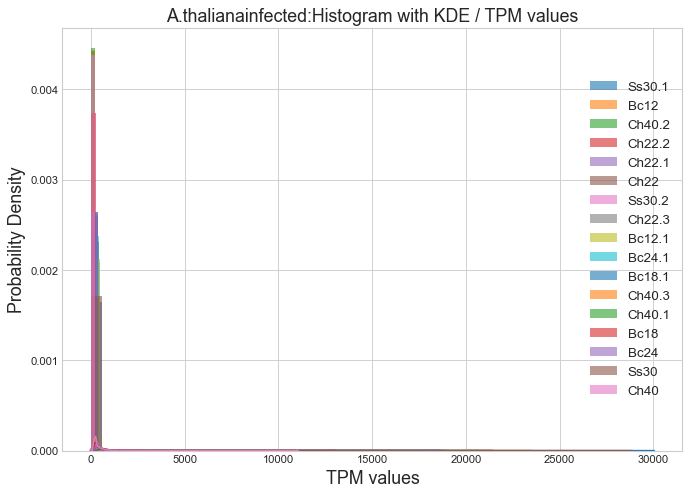

In [14]:
df_KDE(df_plot, sample_lst, general_titles, 'TPM values')

Preparing series for all samples
Preparing series for all atypical


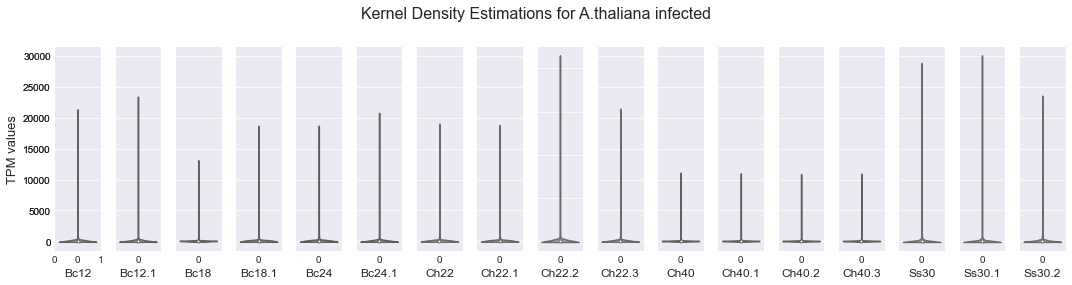

In [15]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_plot, general_titles, 0, False, 'TPM values')

### TPM standarization: Let's to assess the ocurrences of zeros and low and hight extreme TPM values

CV obviously depends very strongly on mean expression such that lowly expressed genes are going to tend to have much higher CV. Therefore, we cannot trust the CV of very lowly expressed genes, and so these should be filtered out of your analysis. If you want a well tested expression filtering scheme, you could use GTEx's scheme (Genes were selected based on expression thresholds of >0.1 TPM in at least 20% of samples and ≥6 reads in at least 20% of samples).

For my own analysis, deleting genes without counts in 70% of the data set seems convenient, because these genes are underrepresented. And the hight expr.levels underrepresented need also be removed. <br>
***Let's start with the counting of genes in zeros***

In [27]:
## Check number of zeros by sample
sr_ceros = df_expr.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

In [28]:
df_ceros[0:5]

,0
Genes,0
Ss30.1,7185
Bc12,4103
Ch40.2,3702
Ch22.2,3770


In [29]:
# Firts, check the number of of ocurrences by row where TPM=0
s_zeros=(df_expr == 0).astype(int).sum(axis=1)
## Added a column to df1 with the counter of zeros
df_expr['zero-counter'] = s_zeros
df_expr.head(5)     # see ID=13 for exampling

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter,Low_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,2,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,2,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,2,0
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041,2,0
4,AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855,1,1


In [30]:
# Second, check the number of ocurrences by row where TPM<0.1
df_expr["Low_TPM"] = df_expr.apply(lambda row: sum(row[1:18]<=0.1) ,axis=1)

In [31]:
df_expr.head(5)   # see ID 13 as example in the infected dataset

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter,Low_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,2,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,2,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,2,0
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041,2,0
4,AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855,1,1


### TPM standarization: Eliminate genes with high occurrences in **Low_TPM** field
I define to remove the genes with **TPM<0.1 in at least 70% of the samples** <br>
e.g: Athal.Infected has 17 samples, thus: <br>
14 x 0.70 = 11.9; Then, rounded the result, I am going to remove genes with  Low_TMP=>12.

In [32]:
if general_titles == 'healthy':
    is_zero = (df_expr['Low_TPM']>=6)     
else:
    is_zero = (df_expr['Low_TPM']>=12)     

df_zero = df_expr[is_zero]
print('genes with 70% of zeros thru the samples:',len(df_zero))
df_zero.head(7)
#df_zero.to_csv('', sep='\t', index=False)

genes with 70% of zeros thru the samples: 3495


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter,Low_TPM
13,AT1G01150,0.000,0.0,0.0,0.0,0.0,0.0,0.213,0.0,0.0,0.047,0.0,0.0,0.0,0.0,0.141,0.000,0.000,14,15
26,AT1G01280,0.000,0.0,0.0,0.0,0.0,0.0,0.124,0.0,0.0,0.608,0.0,0.0,0.0,0.0,0.493,0.000,0.000,14,14
29,AT1G01305,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.416,0.000,0.000,16,16
39,AT1G01400,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.090,0.0,0.0,0.0,0.0,0.089,0.000,0.000,15,17
45,AT1G01460,1.458,0.0,0.0,0.0,0.0,0.0,0.884,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.251,0.091,13,14
97,AT1G01980,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.158,0.000,16,16
106,AT1G02065,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,10.191,0.0,0.0,0.0,0.0,11.677,0.000,0.000,15,15


call the df_drop_idx_list function to delete the indexes marked

In [33]:
print(len(df_expr))
df1 = df_drop_idx_list(df_zero,df_expr)
print(len(df1))
df1.head(5)

24239
20744


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter,Low_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,2,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,2,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,2,0
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041,2,0
4,AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855,1,1


In [34]:
df1.isin([0]).sum()

Genes               0
Ss30.1           4022
Bc12             1194
Ch40.2            846
Ch22.2            751
Ch22.1            696
Ch22              757
Ss30.2           3112
Ch22.3            760
Bc12.1           1113
Bc24.1            481
Bc18.1           1182
Ch40.3            833
Ch40.1            709
Bc18             1111
Bc24              456
Ss30             4236
Ch40              645
zero-counter        0
Low_TPM         13916
dtype: int64

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


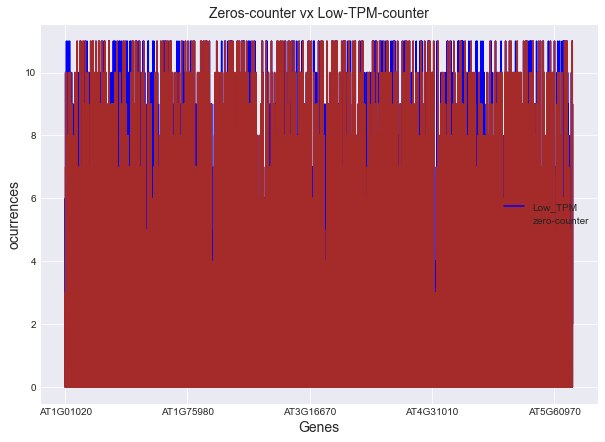

In [24]:
#%whos
ax = plt.gca()
df1.plot(kind='line',x='Genes',y='Low_TPM',color='blue', ax=ax, figsize=(10,7))
df1.plot(kind='line',x='Genes',y='zero-counter', color='brown', ax=ax)
plt.title("Zeros-counter vx Low-TPM-counter",fontsize=14);
plt.xlabel('Genes',fontsize=14);
plt.ylabel('ocurrences',fontsize=14);

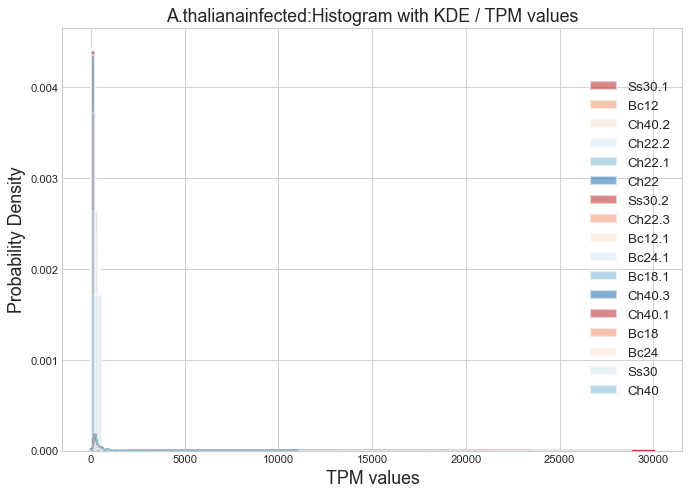

In [35]:
# chk the distribution
df_plot=df1.drop(['Genes','zero-counter','Low_TPM'], axis=1)  
## Get sample list names
df_KDE(df_plot, sample_lst, general_titles , 'TPM values')

Preparing series for all samples
Preparing series for all atypical


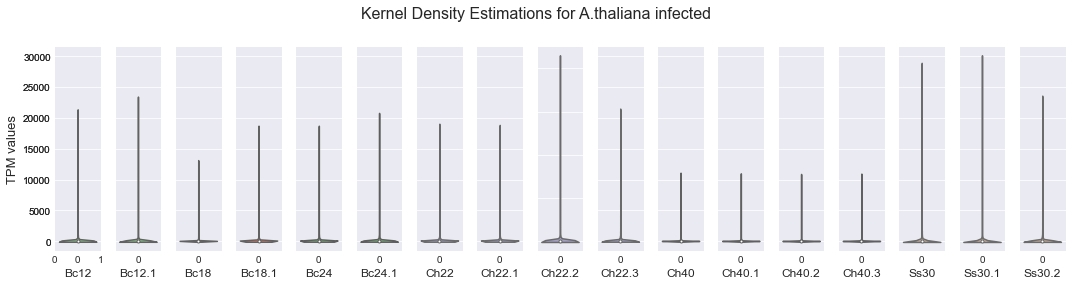

In [36]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_plot, general_titles, 0, False, 'TPM values')

In [368]:
df_stat = df1.describe().T
#df_stat
lst_sd = df_stat['mean'].to_list()
#lst_sd = lst_sd.sort()
lst_sd.sort(reverse=True)
lst_sd

[48.201973862740836,
 48.20170252549064,
 48.20168992260861,
 48.20067770240362,
 48.20026592982212,
 48.19960843698611,
 48.1989287223431,
 48.197672080561816,
 48.19722905791454,
 48.197104178278906,
 48.19637565195442,
 48.195362700377295,
 48.19383762944539,
 48.18886256576221,
 48.18312998682259,
 48.11928274396022,
 48.111678312763836,
 1.302111453914385,
 1.1041264944080216]

In [295]:
maxValues = df_plot.max()
print(maxValues)
minValues = df_plot.min()
print(minValues)

Ss30.1    30046.794
Bc12      21314.028
Ch40.2    10852.459
Ch22.2    21455.952
Ch22.1    18793.409
Ch22      18983.608
Ss30.2    23508.034
Ch22.3    21435.898
Bc12.1    23373.501
Bc24.1    20742.000
Bc18.1    18660.458
Ch40.3    10902.914
Ch40.1    10959.750
Bc18      13089.181
Bc24      18666.461
Ss30      28819.222
Ch40      11056.693
dtype: float64
Ss30.1    0.0
Bc12      0.0
Ch40.2    0.0
Ch22.2    0.0
Ch22.1    0.0
Ch22      0.0
Ss30.2    0.0
Ch22.3    0.0
Bc12.1    0.0
Bc24.1    0.0
Bc18.1    0.0
Ch40.3    0.0
Ch40.1    0.0
Bc18      0.0
Bc24      0.0
Ss30      0.0
Ch40      0.0
dtype: float64


In [148]:
# find the maximum values of each row
maxValues = df1.max(axis = 1)
type(maxValues)
maxValues.sort_values(axis=0, ascending=True)
#print(maxValues)

12032        0.632
10961        0.666
14222        0.691
13426        0.728
20926        0.956
           ...    
11641    16359.589
15091    20742.000
6688     21455.952
4966     23373.501
11516    30046.794
Length: 20744, dtype: float64

<AxesSubplot:>

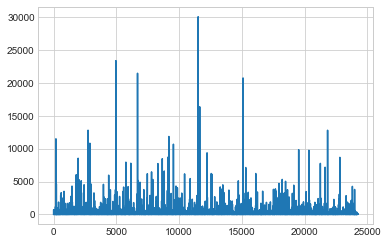

In [149]:
maxValues.plot()

### TPM standarization: Eliminate genes with high occurrences in **Hight_TPM** field
I define to remove the genes with **TPM>1000 in at least 70% of the samples** <br>
e.g: Athal.Infected has 17 samples, thus: <br>
14 x 0.70 = 11.9; Then, rounded the result, I am going to remove genes with  Low_TMP=>12.

In [37]:
# first calculate the 99 percentil and get the maximun value
lst_99_quantile = df1.quantile(.99).to_list()
lst_99_quantile

[829.9260228205225,
 567.794511798489,
 642.5851999190152,
 509.4464070216379,
 528.0143669065774,
 530.3965099449365,
 824.1473506038242,
 507.4894962661667,
 556.5742391529429,
 589.0874994813921,
 572.3230527940304,
 645.3377277942654,
 594.5194894030691,
 581.7825692566596,
 580.2025421327596,
 844.7603292679673,
 591.4689468848633,
 10.0,
 11.0]

In [38]:
df1.head(5)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter,Low_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,2,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,2,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,2,0
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041,2,0
4,AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855,1,1


In [39]:
# Second, check the number of ocurrences by row where TPM<0.1
df1["High_TPM"] = df1.apply(lambda row: sum(row[1:18]>=830) ,axis=1)

In [40]:
b_High_TPM = df1['High_TPM']>=1
df_HTPM = df1[b_High_TPM]
print("Genes above 99 percentil: ",len(df_HTPM))

Genes above 99 percentil:  479


In [41]:
print(len(df1))
df1 = df_drop_idx_list(df_HTPM,df1)
print(len(df1))
df1.head(5)

20744
20265


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,...,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter,Low_TPM,High_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,...,11.980,10.402,13.091,12.592,7.535,4.970,13.503,2,0,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,...,3.086,1.773,1.212,2.682,4.278,4.994,2.248,2,0,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,...,20.774,14.071,15.118,21.153,13.464,2.507,15.940,2,0,0
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,...,96.888,33.258,45.279,88.730,68.733,4.967,41.041,2,0,0
4,AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,...,624.446,29.229,28.791,580.595,2.944,0.167,31.855,1,1,0


In [42]:
# ## funcion obsoleta --> no utilizar 
# ## Filtering across samples
# from collections import defaultdict
# dict_cut = defaultdict(list)

# size_original= len(df1)
# print("current matriz size:",size_original)

# try:
#     ## set a threshold
#     cut_value = 0.1    
#     cut_value = 1000  
#     print("Threshold is set on:",cut_value)
#     b_first=True

#     for sample in sample_lst:   #parse by samples
#         if b_first:
#             df_cut = filter_low_vals_df(df1, (sample, cut_value))
#             b_first = False       
#         else:
#             df_cut = filter_low_vals_df(df_cut, (sample, cut_value))
        
#         size_new = len(df_cut)
#         size = size_original - size_new
#         print(sample+' removed:',str(size))
#         dict_cut['ID'].append(sample)    
#         dict_cut['genes_cut'].append(size)
# except:
#     print("Error")

# df_cut_stats = pd.DataFrame(dict_cut)
# print("new matrix size:",len(df_cut))
# df_cut.head(5)

## save the new matrix filtered of low and extreme high levels
# df1 = df_cut
# df1.drop(['zero-counter'],axis=1, inplace = True)
# df1.to_csv('all_'+general_titles+'_TPM_filtered.csv', sep='\t', index=False)

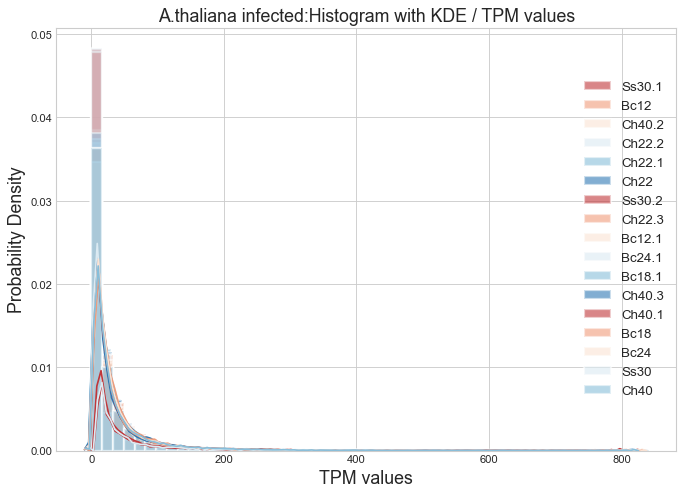

In [47]:
# chk the distribution
#df_plot = df1.drop(['Genes','zero-counter','Low_TPM','High_TPM'], axis=1)   #, inplace = True
## Get sample list names
plt.style.use('seaborn-whitegrid')
df_KDE(df_plot, sample_lst, general_titles , 'TPM values')

Preparing series for all samples
Preparing series for all atypical


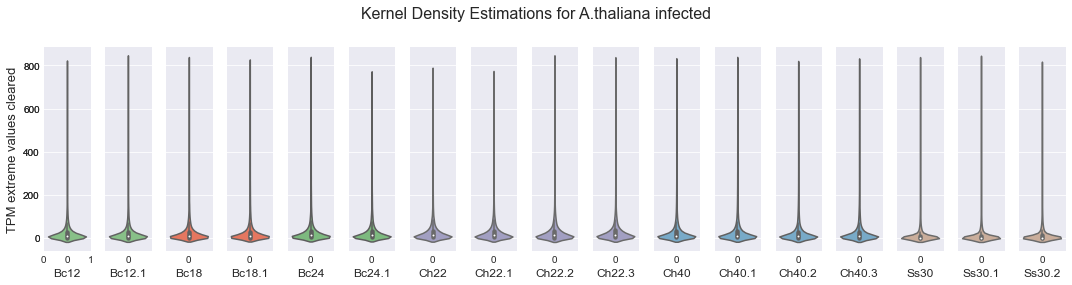

In [375]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_plot, general_titles, 0, False, 'TPM extreme values cleared')

In [376]:
## save the new matrix filtered of low and hight extreme values
df1.drop(['zero-counter','Low_TPM','High_TPM'], axis=1, inplace = True)
df1.to_csv('all_'+general_titles+'_TPM_filtered_new.csv', sep='\t', index=False)

### Let's check some visualizations

In [52]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Ss30.1,20265.0,1.298,1.024,0.0,0.277,1.265,2.202,3.419
Bc12,20265.0,1.937,0.877,0.0,1.474,2.196,2.571,3.413
Ch40.2,20265.0,1.918,0.859,0.0,1.399,2.133,2.565,3.413
Ch22.2,20265.0,2.039,0.833,0.0,1.642,2.296,2.633,3.419
Ch22.1,20265.0,2.018,0.834,0.0,1.596,2.274,2.621,3.401
Ch22,20265.0,2.017,0.838,0.0,1.588,2.271,2.622,3.405
Ss30.2,20265.0,1.428,1.010,0.0,0.454,1.492,2.301,3.412
Ch22.3,20265.0,2.040,0.832,0.0,1.644,2.298,2.633,3.417
Bc12.1,20265.0,1.922,0.878,0.0,1.444,2.184,2.560,3.419
Bc24.1,20265.0,2.033,0.780,0.0,1.624,2.236,2.600,3.401


In [378]:
## save the stats of new matrix filtered
df_stat = df1.describe().T
df_stat.to_csv("../statistics/all_TPM_filtered_new_"+general_titles+"_stats.csv", index=True, header=True)

In [381]:
lst_stat = df_stat['mean'].to_list()
lst_stat.sort()
lst_stat

[20.79552028676744,
 20.84546200757425,
 22.742126092197157,
 29.000576078609082,
 29.892132407730383,
 30.24770040476321,
 30.764044331263232,
 30.849954050774116,
 30.86404751843721,
 31.009366576395067,
 31.142326270769694,
 31.585182030727704,
 31.60141706945975,
 32.38430999487013,
 32.397340310570854,
 33.353086378764125,
 33.38254477521881]

In [53]:
df1.head(3)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,...,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter,Low_TPM,High_TPM
0,AT1G01020,1.863,2.194,2.240,2.398,2.340,2.381,1.773,2.432,2.171,...,2.232,2.174,2.268,2.252,2.033,1.839,2.280,1.37,0.0,0.0
1,AT1G01030,2.001,0.858,1.255,1.256,1.129,1.137,2.039,1.073,1.381,...,1.600,1.305,1.101,1.526,1.765,1.841,1.433,1.37,0.0,0.0
2,AT1G01040,1.291,2.412,2.309,2.504,2.446,2.426,1.551,2.515,2.419,...,2.445,2.297,2.325,2.451,2.279,1.491,2.345,1.37,0.0,0.0


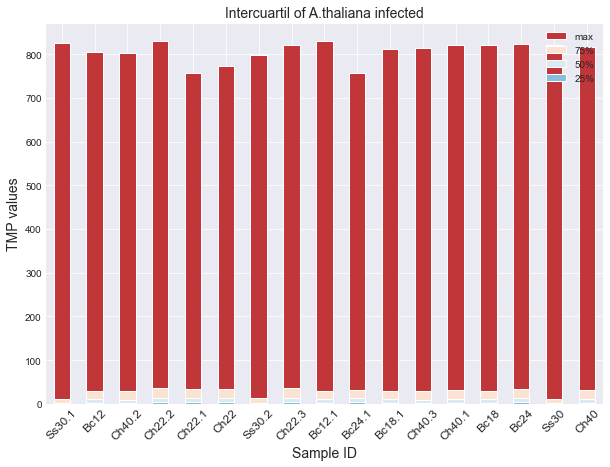

In [383]:
plot_intercuartile_bar(df_stat, "Intercuartil of A.thaliana " + general_titles, 'TMP values' )

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


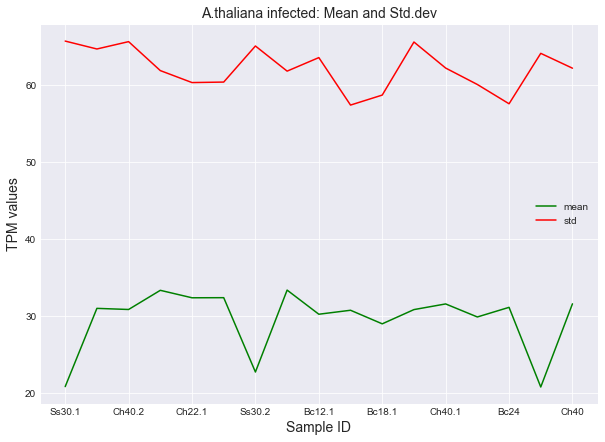

In [384]:
plot_mean_sdev_line(df_stat, 'A.thaliana '+ general_titles +': Mean and Std.dev','TPM values')

## Let's to apply log2 to reduce the scale effect
Exist the possibility to have to apply log2 to reduce the scale effect. Take in account that the lowest TPM values will turn negative, but they are in fact positive. <br>
Will turn to a normal distribution to apply a log transformation? 
https://en.wikipedia.org/wiki/Log-normal_distribution

In [49]:
print(len(df1))
df1.head(2)

20265


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,...,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter,Low_TPM,High_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,...,11.980,10.402,13.091,12.592,7.535,4.970,13.503,2,0,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,...,3.086,1.773,1.212,2.682,4.278,4.994,2.248,2,0,0


In [51]:
## Plus 1 to avoid arithmetical error and apply Log2 transformation (avoid error div/0)
for column in df1.select_dtypes(include = [np.number]).columns:
#for column in col_name:
    #print(column)
    df1[column] += 1
    ## Apply Log2 numpy function to absolute values and add a column
    df1[column] = np.log2(df1[column])
df1.head(5)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,...,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter,Low_TPM,High_TPM
0,AT1G01020,1.863,2.194,2.240,2.398,2.340,2.381,1.773,2.432,2.171,...,2.232,2.174,2.268,2.252,2.033,1.839,2.280,1.37,0.0,0.0
1,AT1G01030,2.001,0.858,1.255,1.256,1.129,1.137,2.039,1.073,1.381,...,1.600,1.305,1.101,1.526,1.765,1.841,1.433,1.37,0.0,0.0
2,AT1G01040,1.291,2.412,2.309,2.504,2.446,2.426,1.551,2.515,2.419,...,2.445,2.297,2.325,2.451,2.279,1.491,2.345,1.37,0.0,0.0
3,AT1G01050,1.618,3.009,2.623,2.781,2.784,2.771,2.047,2.811,3.020,...,2.928,2.608,2.708,2.904,2.833,1.839,2.677,1.37,0.0,0.0
4,AT1G01060,0.369,2.628,2.546,2.456,2.151,2.127,0.126,2.437,2.651,...,3.363,2.565,2.560,3.348,1.575,0.290,2.594,1.00,1.0,0.0


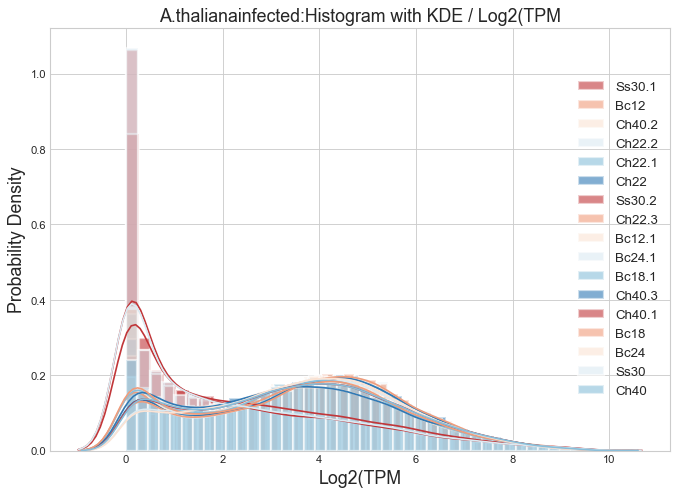

In [395]:
# chk the distribution
df_plot = df1.drop(['Genes'], axis=1)  
## Get sample list names
df_KDE(df_plot, sample_lst, general_titles , 'Log2(TPM)')

In [396]:
df_log2=df1

In [397]:
df_log2.head(2)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,2.638,3.577,3.723,4.272,4.062,4.211,2.419,4.397,3.505,3.025,3.698,3.511,3.817,3.765,3.093,2.578,3.858
1,AT1G01030,3.002,0.813,1.386,1.389,1.187,1.199,3.109,1.103,1.604,2.559,2.031,1.471,1.145,1.881,2.400,2.584,1.700


In [398]:
## save the new matrix filtered of low and extreme high levels
df_log2.to_csv('all_'+general_titles+'_Log2TPM_filtered_new.csv', sep='\t', index=False)

Preparing series for all samples
Preparing series for all atypical


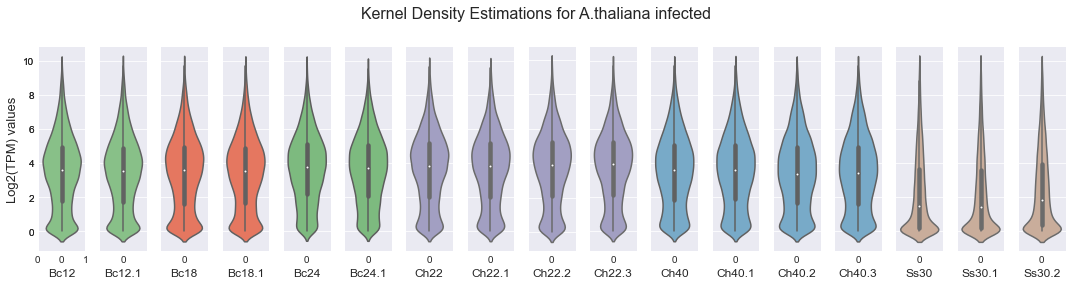

In [400]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_log2, general_titles, 0, False, 'Log2(TPM) values')

**A bit of stats**

In [401]:
## save the stats of new matrix filtered
df_stat=df_log2.describe().T
print("Stats for A.thaliana Log2(TPM) dataset")
df_stat
df_stat.to_csv("../statistics/all_Log2TPM_filtered_new"+general_titles+"_stats.csv", index=True, header=True)

Stats for A.thaliana Log2(TPM) dataset


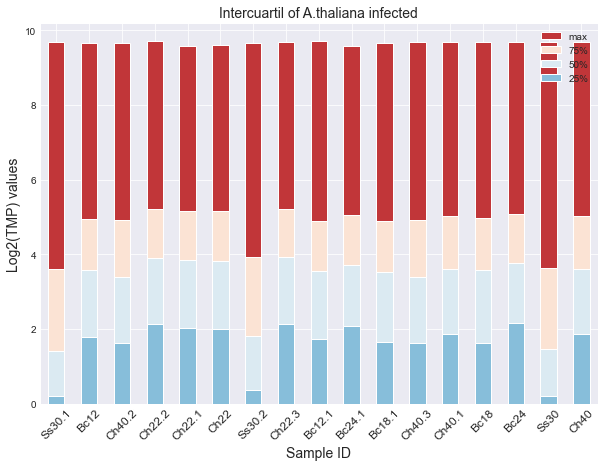

In [408]:
plot_intercuartile_bar(df_stat, "Intercuartil of A.thaliana " + general_titles, 'Log2(TMP) values' )

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


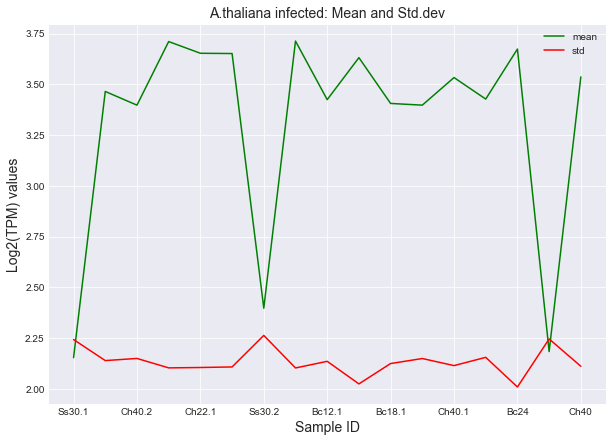

In [409]:
plot_mean_sdev_line(df_stat, 'A.thaliana '+ general_titles +': Mean and Std.dev','Log2(TPM) values')

In [411]:
lst_stat=df_stat['mean'].to_list()
lst_stat.sort()
lst_stat

[2.153659438702512,
 2.18376228011647,
 2.3972776903723703,
 3.3972120583152248,
 3.397249818681368,
 3.4055964224126356,
 3.4242437248401596,
 3.4271786090718805,
 3.4645509678938033,
 3.5330804578532833,
 3.5362926862173314,
 3.631138350120185,
 3.6513498229484163,
 3.6527091159070366,
 3.6734852135235347,
 3.7103427180503865,
 3.7127528200491606]

***KDE samples SS30*** <br>
https://stackabuse.com/seaborn-violin-plot-tutorial-and-examples/

In [412]:
violin_plot

<function __main__.violin_plot(dfx, ds, atypical, b_swarm, ylab)>

Preparing series for all samples
Preparing series for all atypical


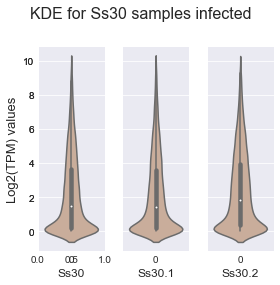

In [413]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_log2, general_titles, 2, False, 'Log2(TPM) values')

**Take an overview for central values and distributions for the entire dataset**

In [414]:
dfx = df_log2
dfx

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,2.638,3.577,3.723,4.272,4.062,4.211,2.419,4.397,3.505,3.025,3.698,3.511,3.817,3.765,3.093,2.578,3.858
1,AT1G01030,3.002,0.813,1.386,1.389,1.187,1.199,3.109,1.103,1.604,2.559,2.031,1.471,1.145,1.881,2.400,2.584,1.700
2,AT1G01040,1.446,4.321,3.955,4.673,4.450,4.374,1.930,4.716,4.350,3.896,4.445,3.914,4.011,4.469,3.854,1.810,4.082
3,AT1G01050,2.069,7.048,5.161,5.874,5.890,5.826,3.133,6.017,7.109,5.916,6.613,5.098,5.532,6.488,6.124,2.577,5.394
4,AT1G01060,0.291,5.183,4.839,4.486,3.440,3.367,0.091,4.414,5.281,2.309,9.289,4.918,4.897,9.184,1.980,0.223,5.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24234,ATMG01350,0.000,0.390,2.313,1.921,1.746,0.845,0.544,1.386,0.587,0.268,1.136,2.796,2.507,0.000,0.266,0.000,2.393
24235,ATMG01360,2.962,2.061,5.502,4.252,4.368,4.130,2.599,4.121,1.687,0.884,1.868,5.614,5.035,1.901,1.045,2.588,5.023
24236,ATMG01370,1.606,3.623,6.756,6.675,6.162,6.348,3.028,6.745,3.435,2.984,3.222,6.768,7.050,3.756,3.155,3.545,7.024
24237,ATMG01400,0.000,0.000,1.400,0.631,0.624,0.631,0.000,1.415,0.000,0.000,0.000,2.096,1.464,0.000,0.000,0.000,0.665


### More stats for the atypical distributions: Ss30 
Let's remove them and analize the effect

In [415]:
df_log2.head(2)
df_log2.drop(['Ss30.1','Ss30.2','Ss30'], axis='columns', inplace=True)

In [416]:
print(len(df_log2.columns))
df_log2.head(2)

15


,Genes,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ch40
0,AT1G01020,3.577,3.723,4.272,4.062,4.211,4.397,3.505,3.025,3.698,3.511,3.817,3.765,3.093,3.858
1,AT1G01030,0.813,1.386,1.389,1.187,1.199,1.103,1.604,2.559,2.031,1.471,1.145,1.881,2.400,1.700


**A bit of stats**

In [417]:
## save the stats of new matrix filtered
df_stat=df_log2.describe().T
print("Stats for A.thaliana Log2(TPM) dataset / No Ss30 samples")
df_stat

Stats for A.thaliana Log2(TPM) dataset / No Ss30 samples


,count,mean,std,min,25%,50%,75%,max
Bc12,20265.0,3.465,2.139,0.0,1.777,3.581,4.940,9.654
Ch40.2,20265.0,3.397,2.150,0.0,1.638,3.386,4.916,9.650
Ch22.2,20265.0,3.710,2.103,0.0,2.121,3.910,5.204,9.697
Ch22.1,20265.0,3.653,2.105,0.0,2.022,3.835,5.152,9.567
Ch22,20265.0,3.651,2.108,0.0,2.006,3.828,5.156,9.595
Ch22.3,20265.0,3.713,2.103,0.0,2.126,3.918,5.203,9.683
Bc12.1,20265.0,3.424,2.136,0.0,1.721,3.544,4.897,9.697
Bc24.1,20265.0,3.631,2.024,0.0,2.082,3.711,5.061,9.565
Bc18.1,20265.0,3.406,2.125,0.0,1.656,3.536,4.894,9.665
Ch40.3,20265.0,3.397,2.149,0.0,1.629,3.395,4.920,9.671


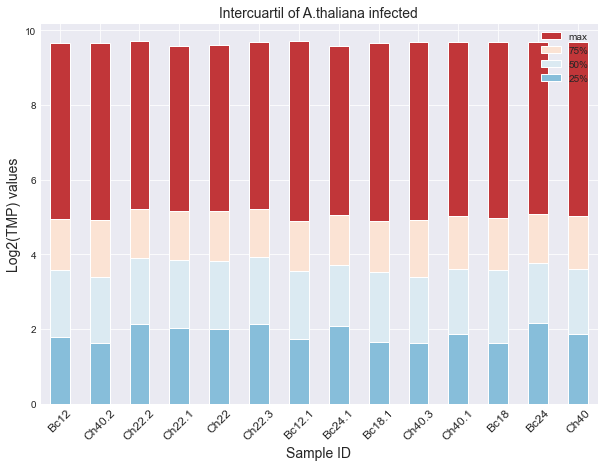

In [418]:
plot_intercuartile_bar(df_stat, "Intercuartil of A.thaliana " + general_titles, 'Log2(TMP) values' )

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


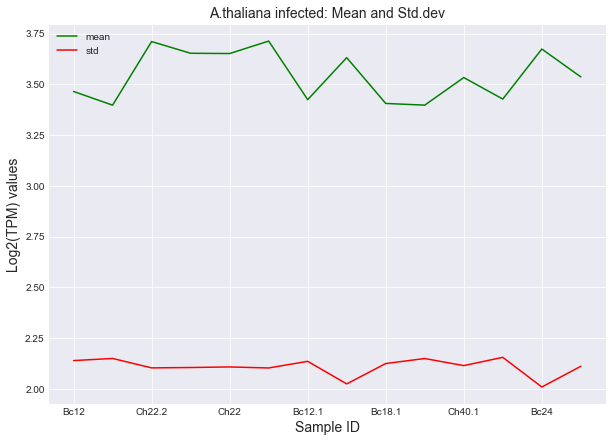

In [419]:
plot_mean_sdev_line(df_stat, 'A.thaliana '+ general_titles +': Mean and Std.dev','Log2(TPM) values')

In [433]:
lst_stat=df_stat['mean'].to_list()
lst_stat.sort()
lst_stat

[3.3972120583152248,
 3.397249818681368,
 3.4055964224126356,
 3.4242437248401596,
 3.4271786090718805,
 3.4645509678938033,
 3.5330804578532833,
 3.5362926862173314,
 3.631138350120185,
 3.6513498229484163,
 3.6527091159070366,
 3.6734852135235347,
 3.7103427180503865,
 3.7127528200491606]

***KDE without the Ss30 samples***

In [427]:
sample_lst=df1.columns.to_list()
sample_lst.remove('Genes')
# sample_lst.remove('Ss30.1')
# sample_lst.remove('Ss30.2')
# sample_lst.remove('Ss30')
sample_lst

['Bc12',
 'Ch40.2',
 'Ch22.2',
 'Ch22.1',
 'Ch22',
 'Ch22.3',
 'Bc12.1',
 'Bc24.1',
 'Bc18.1',
 'Ch40.3',
 'Ch40.1',
 'Bc18',
 'Bc24',
 'Ch40']

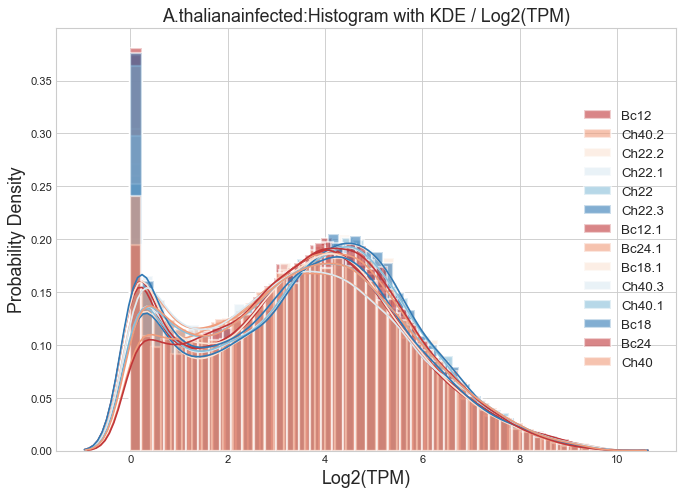

In [428]:
# chk the distribution
df_KDE(df_log2, sample_lst, general_titles, 'Log2(TPM)')

***Violin plot with KDE without Ss30***

Preparing series for all samples


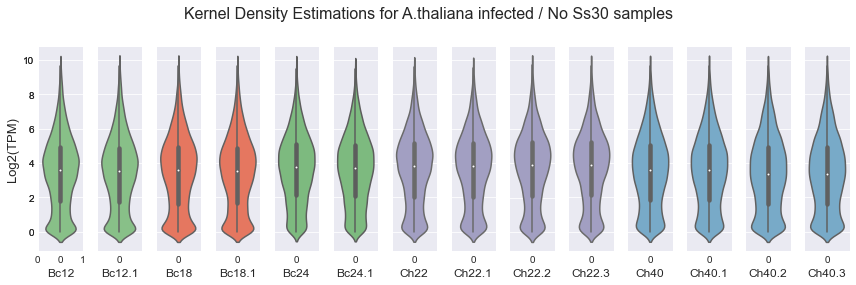

In [429]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_log2, general_titles, 1, False, 'Log2(TPM)')

In [430]:
## save the new matrix filtered of low and extreme high levels
df_log2.to_csv('all_'+general_titles+'_Log2TPM_No_Ss30_new.csv', sep='\t', index=False)

In [432]:
## save the stats of new matrix filtered
df_stat=df_log2.describe().T
df_stat.to_csv("../statistics/all_Log2TPM_No_Ss30_"+general_titles+"_stats_new.csv", index=True, header=True)

### To finish, let's to merge A.thaliana healthy and infected in one matrix (inner operation)

In [111]:
df_healty=pd.read_csv("all_healthy_Log2TPM_filtered.csv", header=0, sep='\t', engine='python')
print(len(df_healty))
df_healty.head(5)
df_infected=pd.read_csv("all_infected_Log2TPM_No_Ss30.csv", sep='\t', engine='python')
print(len(df_infected))
df_infected.head(5)

17246
13562


,Genes,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ch40
0,AT1G01020,3.451,3.609,4.195,3.973,4.131,4.327,3.371,2.835,3.583,3.379,3.711,3.654,2.914,3.755
1,AT1G01030,-0.402,0.690,0.695,0.353,0.373,0.200,1.029,2.291,1.626,0.826,0.277,1.423,2.097,1.169
2,AT1G01040,4.247,3.858,4.616,4.382,4.303,4.660,4.277,3.796,4.377,3.815,3.918,4.403,3.751,3.995
3,AT1G01050,7.037,5.121,5.849,5.865,5.800,5.994,7.099,5.892,6.598,5.056,5.501,6.471,6.103,5.359
4,AT1G01070,2.611,3.075,1.887,2.934,2.472,1.762,2.584,2.324,2.254,2.996,2.679,2.671,2.562,2.857


In [112]:
#result = pd.merge(df_infected, df_healty, on='Gene')
result = df_infected.merge(df_healty,on=['Genes'],how='inner')

In [113]:
print(len(result))
result.head(5)

13228


,Genes,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ch22.3,Bc12.1,Bc24.1,Bc18.1,...,Bc24,Ch40,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,AT1G01020,3.451,3.609,4.195,3.973,4.131,4.327,3.371,2.835,3.583,...,2.914,3.755,3.084,2.831,3.312,3.012,2.857,3.095,3.567,3.210
1,AT1G01030,-0.402,0.690,0.695,0.353,0.373,0.200,1.029,2.291,1.626,...,2.097,1.169,0.657,0.829,0.959,0.544,0.880,1.274,0.668,-0.098
2,AT1G01040,4.247,3.858,4.616,4.382,4.303,4.660,4.277,3.796,4.377,...,3.751,3.995,4.835,4.656,4.452,4.402,4.154,3.780,4.562,3.912
3,AT1G01050,7.037,5.121,5.849,5.865,5.800,5.994,7.099,5.892,6.598,...,6.103,5.359,6.656,6.742,6.731,6.833,6.871,5.680,6.803,5.891
4,AT1G01070,2.611,3.075,1.887,2.934,2.472,1.762,2.584,2.324,2.254,...,2.562,2.857,0.742,2.034,1.773,3.391,3.153,2.326,1.652,3.609


In [114]:
## save the union matrix 
#result.to_csv('all_Log2TPM_inner.csv', sep='\t', index=False)

In [115]:
## save the stats of new union matrix
df_stat=result.describe().T
#df_stat.to_csv("../statistics/all_Log2TPM_inner_stats.csv", index=True, header=True)
df_stat

,count,mean,std,min,25%,50%,75%,max
Bc12,13228.0,4.176,1.901,-3.290,3.039,4.177,5.366,9.851
Ch40.2,13228.0,4.253,1.923,-3.197,3.011,4.225,5.496,9.953
Ch22.2,13228.0,4.611,1.712,-3.216,3.596,4.630,5.679,9.941
Ch22.1,13228.0,4.566,1.721,-2.797,3.531,4.581,5.655,9.941
Ch22,13228.0,4.565,1.725,-2.968,3.516,4.582,5.643,9.940
Ch22.3,13228.0,4.615,1.704,-2.465,3.590,4.635,5.680,9.901
Bc12.1,13228.0,4.128,1.906,-2.756,2.986,4.136,5.316,9.890
Bc24.1,13228.0,4.435,1.746,-2.966,3.315,4.452,5.573,9.926
Bc18.1,13228.0,4.203,1.852,-3.319,3.089,4.219,5.382,9.564
Ch40.3,13228.0,4.252,1.927,-3.128,3.023,4.221,5.491,9.930


In [116]:
# chk the distribution
sample_lst = result.columns.to_list()
sample_lst.remove('Genes')
sample_lst
df_plot = result.drop(['Genes'], axis='columns')
df_plot.head(2)
#df_KDE(df_log2, sample_lst, '/ Log2(TPM) normalization', 'Log2(TPM)')

,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,...,Bc24,Ch40,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,3.451,3.609,4.195,3.973,4.131,4.327,3.371,2.835,3.583,3.379,...,2.914,3.755,3.084,2.831,3.312,3.012,2.857,3.095,3.567,3.210
1,-0.402,0.690,0.695,0.353,0.373,0.200,1.029,2.291,1.626,0.826,...,2.097,1.169,0.657,0.829,0.959,0.544,0.880,1.274,0.668,-0.098


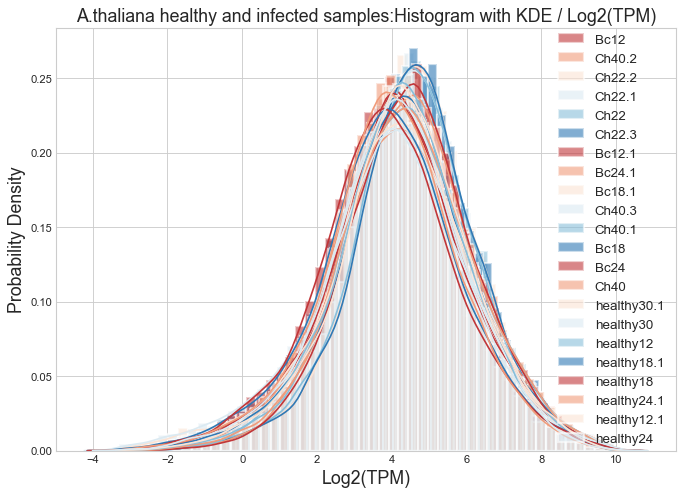

In [117]:
df_KDE(df_plot, sample_lst, ' healthy and infected samples', 'Log2(TPM)')